In [1]:
train_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\new622\train'
test_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\new622\test'
val_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\new622\val'

In [2]:
import os
import keras
import numpy as np
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers.pooling import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, save_model, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,Activation
from sklearn.metrics import accuracy_score, average_precision_score, precision_score, f1_score, recall_score


In [3]:
dim = (176,208)           
zoom = [.9, 1.1]          
bright_range = [.8,1.2]       

In [5]:
batch_size = 32

dim = (176, 208)
inputShape = (176, 208, 3)
train_Generator = ImageDataGenerator(rescale=1/255, fill_mode='constant', cval=0,
                               brightness_range=[0.8, 1.2], zoom_range=[0.9, 1.1], horizontal_flip=True)
train_data = train_Generator.flow_from_directory(train_root, target_size=dim, batch_size=batch_size)


Generator = ImageDataGenerator(rescale=1/255, fill_mode='constant', cval=0)
Generator_TTA = ImageDataGenerator(rescale=1/255, fill_mode='constant', cval=0, horizontal_flip=True)

train_data_original=Generator.flow_from_directory(train_root, target_size=dim, batch_size=batch_size)
val_data = Generator.flow_from_directory(val_root, target_size=dim, batch_size=batch_size)
test_data = Generator.flow_from_directory(test_root, target_size=dim, batch_size=batch_size, shuffle=False)
test_data_TTA = Generator_TTA.flow_from_directory(test_root, target_size=dim, batch_size=batch_size, shuffle=False)

num_classes = len([i for i in os.listdir(train_root)])
print(num_classes)

Found 6852 images belonging to 4 classes.
Found 6852 images belonging to 4 classes.
Found 2283 images belonging to 4 classes.
Found 2289 images belonging to 4 classes.
Found 2289 images belonging to 4 classes.
4


In [6]:
import random

args = 12
np.random.seed(args)

random.seed(args)              ##

# opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD') 
adam=tf.keras.optimizers.Adam(learning_rate=0.001)

In [7]:
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=12, verbose=1, mode='max', restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, mode='max', cooldown=1, min_lr=1e-8)
callback_list = [earlyStopping, reduce]


In [8]:
res_model = tf.keras.applications.resnet.ResNet50(include_top=False, 
                                                weights='imagenet', 
                                                input_shape=(dim[0],dim[1],3),
                                                   pooling="max", 
                                                   classes=4)
#     res_model.trainable = False
res_model.get_layer('conv2_block1_2_conv').trainable = False
res_model.get_layer('conv2_block1_3_conv').trainable = False
#     res_model.get_layer('conv2_block1_0_conv').trainable = True
#     res_model.get_layer('conv2_block1_3_conv').trainable = True
#     res_model.get_layer('conv2_block2_1_conv').trainable = False
res_model.get_layer('conv2_block2_3_conv').trainable = False

res_model.get_layer('conv3_block3_2_conv').trainable = False
res_model.get_layer('conv3_block3_3_conv').trainable = False

#     res_model.get_layer('conv3_block4_1_conv').trainable = False
res_model.get_layer('conv3_block4_2_conv').trainable = False

res_model.get_layer('conv4_block1_2_conv').trainable = False
res_model.get_layer('conv4_block1_3_conv').trainable = False

res_model.get_layer('conv4_block2_2_conv').trainable = False
res_model.get_layer('conv4_block2_3_conv').trainable = False

res_model.get_layer('conv4_block3_2_conv').trainable = False
res_model.get_layer('conv4_block3_3_conv').trainable = False

res_model.get_layer('conv4_block4_2_conv').trainable = False
res_model.get_layer('conv4_block4_3_conv').trainable = False

res_model.get_layer('conv4_block5_2_conv').trainable = False
res_model.get_layer('conv4_block5_3_conv').trainable = False

res_model.get_layer('conv5_block3_2_conv').trainable = False
res_model.get_layer('conv5_block3_3_conv').trainable = False
#     res_model.get_layer('conv4_block6_2_conv').trainable = False
#     res_model.get_layer('conv4_block6_3_conv').trainable = False


res_model.summary()
    



model=Sequential()
model.add(res_model)
# model.add(Flatten())

model.add(Dense(1024,
                kernel_regularizer=regularizers.l2(0.0001),
                kernel_initializer='he_uniform')
          )
model.add(BatchNormalization())
model.add(Activation('relu'))
#     model.add(Dropout(0.25) )
model.add(Dropout(0.3) )

model.add(Dense(4,activation='softmax') )
model.summary()




Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 208, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 182, 214, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 88, 104, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 88, 104, 64)  256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 44, 52, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 44, 52, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 44, 52, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 44, 52, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 22, 26, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 22, 26, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 22, 26, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 22, 26, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 11, 13, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 11, 13, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 11, 13, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 11, 13, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 11, 13, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 11, 13, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 11, 13, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 11, 13, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

 conv5_block2_1_conv (Conv2D)   (None, 6, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 6, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 6, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 6, 7, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

In [10]:
model.compile(optimizer=adam, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
model_history = model.fit(train_data,validation_data=val_data,callbacks= callback_list,
                             epochs=100, shuffle=True)

Epoch 1/100
215/215 [==============================] - 91s 363ms/step - loss: 1.3011 - accuracy: 0.5560 - val_loss: 1.3968 - val_accuracy: 0.4985 - lr: 0.0010
Epoch 2/100
215/215 [==============================] - 79s 365ms/step - loss: 0.9861 - accuracy: 0.6623 - val_loss: 1.4424 - val_accuracy: 0.4985 - lr: 0.0010
Epoch 3/100
215/215 [==============================] - 81s 376ms/step - loss: 0.8662 - accuracy: 0.7091 - val_loss: 14.1276 - val_accuracy: 0.4985 - lr: 0.0010
Epoch 4/100
215/215 [==============================] - 83s 382ms/step - loss: 0.7442 - accuracy: 0.7548 - val_loss: 1.2094 - val_accuracy: 0.4477 - lr: 0.0010
Epoch 5/100
215/215 [==============================] - 105s 489ms/step - loss: 0.6522 - accuracy: 0.7890 - val_loss: 0.7241 - val_accuracy: 0.7521 - lr: 0.0010
Epoch 6/100
215/215 [==============================] - 91s 422ms/step - loss: 0.5505 - accuracy: 0.8259 - val_loss: 0.8740 - val_accuracy: 0.7210 - lr: 0.0010
Epoch 7/100
215/215 [=======================

In [12]:
def get_result_2(model_history,vg_model,test_data,test_data_TTA):
    #     train_scores = vg_model.evaluate(train_data, train_labels)
#     val_scores = vg_model.evaluate(val_data,val_labels)
    test_scores = vg_model.evaluate(test_data)

#     print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
#     print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
    print('Test Accuracy: %.2f%%'%(test_scores[1]*100))
    
    fig, ax = plt.subplots(1, 2, figsize = (30, 5))
    ax = ax.ravel()

    for i, metric in enumerate(["accuracy", "loss"]):
        ax[i].plot(model_history.history[metric])
        ax[i].plot(model_history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])
        
    pred = vg_model.predict(test_data)
    pred=np.argmax(pred,axis=1)
    
    # TTA_WAY

    cm = confusion_matrix(y_true= test_data.classes,y_pred=pred,labels=[0,1,2,3])

    # sns.heatmap(cm,annot = True)
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = sn.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Non', 'VeryMild'],
            yticklabels=['Mild', 'Moderate', 'Non', 'VeryMild'])
    plt.title('Alzheimer\'s Diagnosis')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    # plt.subplots(figsize=(9, 6))
    plt.show(ax)
    print('------Weighted------')
    print('Weighted precision', precision_score(test_data.classes, pred, average='weighted'))
    print('Weighted recall', recall_score(test_data.classes, pred, average='weighted'))
    print('Weighted f1-score', f1_score(test_data.classes, pred, average='weighted'))
    print('------Macro------')
    print('Macro precision', precision_score(test_data.classes, pred, average='macro'))
    print('Macro recall', recall_score(test_data.classes, pred, average='macro'))
    print('Macro f1-score', f1_score(test_data.classes, pred, average='macro'))
    print('------Micro------')
    print('Micro precision', precision_score(test_data.classes, pred, average='micro'))
    print('Micro recall', recall_score(test_data.classes, pred, average='micro'))
    print('Micro f1-score', f1_score(test_data.classes, pred, average='micro'))
    
    tta_steps = 10

    predictions = []
    
    for i in range(tta_steps):
    #     preds = model.predict_generator(test_datagen.flow(test_data, batch_size=batch_size, shuffle=False), steps = len(test_data)/batch_size)
        preds = model.predict(test_data_TTA,verbose=1)
        predictions.append(preds)

    final_pred = np.mean(predictions, axis=0)
    pred = np.argmax(final_pred, axis=-1)
    true = test_data.classes
    
    print('------TTA_SCORE------')
    print(f'Accuracy with TTA: {np.mean(np.equal(pred,true))}')
    


72/72 [==============================] - 13s 169ms/step - loss: 0.0621 - accuracy: 0.9908
Test Accuracy: 99.08%
72/72 [==============================] - 7s 79ms/step


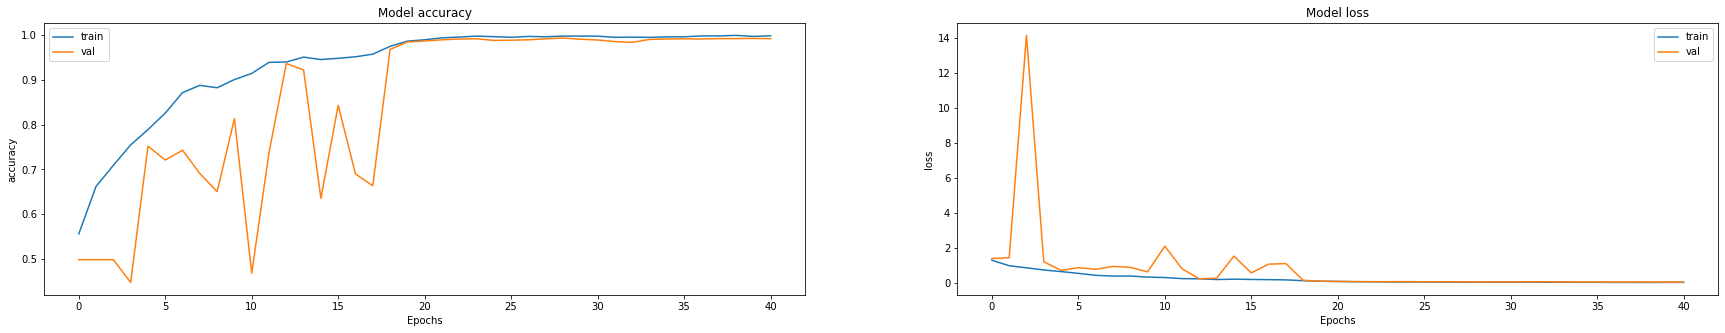

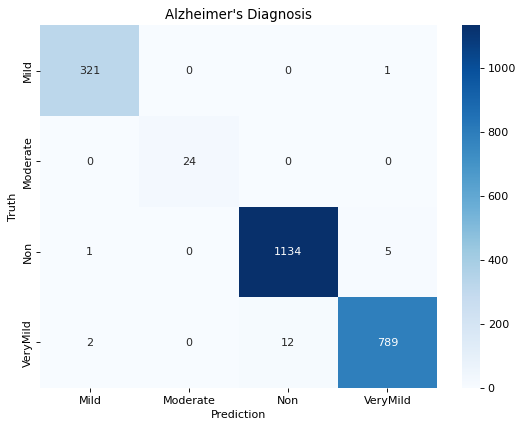

------Weighted------
Weighted precision 0.9908348485736824
Weighted recall 0.9908256880733946
Weighted f1-score 0.9908168420355988
------Macro------
Macro precision 0.9931805916852345
Macro recall 0.9935491579672013
Macro f1-score 0.9933545973079694
------Micro------
Micro precision 0.9908256880733946
Micro recall 0.9908256880733946
Micro f1-score 0.9908256880733946
72/72 [==============================] - 7s 97ms/step
------TTA_SCORE------
Accuracy with TTA: 0.9930100480559196


In [13]:
get_result_2(model_history,model,test_data,test_data_TTA)


In [ ]:
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow as tf
import gc
 
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
 
    try:
        del classifier # this is from global space - change this as you need
    except:
        pass
 
    print(gc.collect()) # if it does something you should see a number as output
 
    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))
reset_keras()